In [1]:
#July 28
"""
Adding in a star-forming fraction to account for the difference of sf vs quiescent galaxies
"""

import ares
import numpy as np
import matplotlib.pyplot as pl

In [2]:
pop_halo = ares.populations.HaloPopulation()
data = ares.analysis.GalaxyPopulation() #for lit values

#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 2.0 #0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)


# OutputArr_47873077.txt averages
beta_0, beta_1, N_0, nu, gamma_0, gamma_1, logM_0, mu = [0.8873238682124077, -0.03555562381943656, 0.010417143384991343, 0.2796315756493593, \
 0.5625588540287767, 0.178661444680813, 11.748076293655107, 1.8525755484303332]

### Putting it into ARES

In [3]:
base_pars = ares.util.ParameterBundle('emma:model3')

'''
a - slope, must be -ve (more negative, steep = faster change)
    --> funct of z, more negative with higher z
b - peak, switch which one is bigger
c - vertical width (bigger = narrower)
d - shift vertically (up = bigger)
'''

guesses = \
{
     #A
        'pq_func_par0[7]': -1.5, #const
        #'pq_func_par1[7]': 0.875, #offset
        'pq_func_par2[7]': 0.1, #m

    #B
        'pq_func_par0[8]': -10.24, #const
        #'pq_func_par1[8]': 1.75, #offset
        'pq_func_par2[8]': 0.06, #m

    #C
        'pq_func_par0[9]': 2.25, #const
        'pq_func_par2[9]': 0.3,
    #D
        'pq_func_par0[10]': 1.4, #const
        'pq_func_par2[10]': 0.2,
}

base_pars.update(guesses)
pop = ares.populations.GalaxyPopulation(**base_pars)

fract = pop._SF_fraction_PQ(sf_type='smf_sf')

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


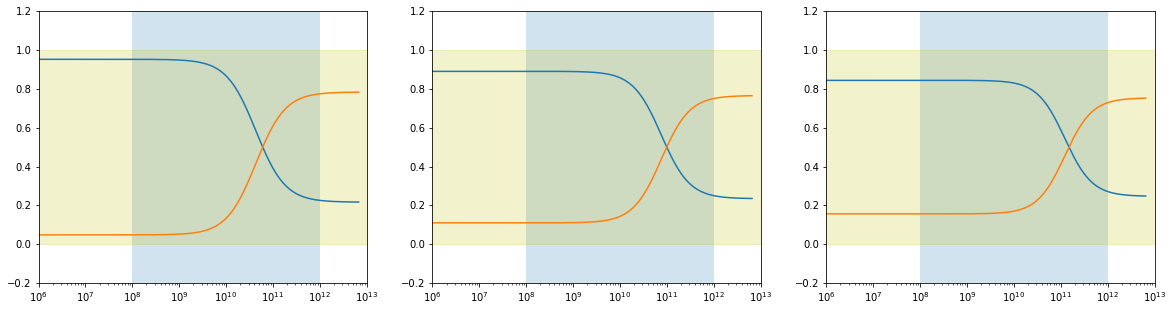

In [4]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

for i, z in enumerate([0.875, 1.75, 2.75]):

    axs[i].axvspan(10**8, 10**12, alpha=0.2)
    axs[i].semilogx(pop.SMHM(z, 0), fract(z=z, Sh=pop.SMHM(z, 0)))
    axs[i].semilogx(pop.SMHM(z, 0), 1-fract(z=z, Sh=pop.SMHM(z, 0)))
    axs[i].axhspan(0, 1, alpha=0.2, color="y")

    axs[i].set_xlim(1e6, 1e13)
    axs[i].set_ylim(-0.2, 1.2)

pl.show()

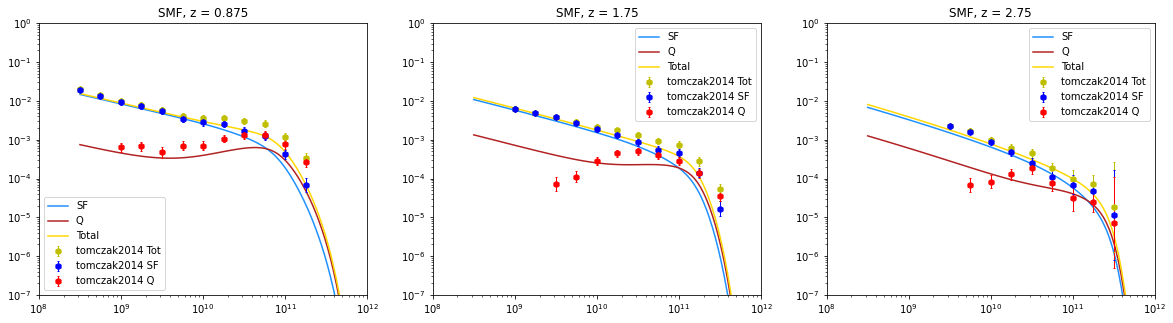

In [5]:
Sm = np.linspace(8.5, 12.1, num=100)
# z = 0.875
z = 2.25

fig, axs = pl.subplots(1, 3, figsize=(20, 5))

for i, z in enumerate([0.875, 1.75, 2.75]):
    
    smf_sf = pop.StellarMassFunction(z, Sm, sf_type='smf_sf')
    axs[i].loglog(10**Sm, smf_sf, label='SF', color="dodgerblue")

    smf_q = pop.StellarMassFunction(z, Sm, sf_type='smf_q')
    axs[i].loglog(10**Sm, smf_q, label='Q', color="firebrick")

    smf = pop.StellarMassFunction(z, Sm)
    axs[i].loglog(10**Sm, smf, label='Total', color="gold")

    data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 Tot", quantity="smf_tot", ax=axs[i])
    data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 SF", color="b", ecolor='b',  mec='b', ax=axs[i])
    data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 Q", quantity="smf_q", ax=axs[i])

    axs[i].set_title("SMF, z = {}".format(z))
    axs[i].legend()
    axs[i].set_xlim(1e8, 1e12)
pl.show()

#### Quenched vs SF
For given mass, what is chance it is quenched?  
Parametrize # objects that are quenched wrt (mass, z)

$SF_{fract} = m \cdot log10(halo~mass) + b$   
Then get the galaxy density we have:   
    Star-forming: $Dn/dm \cdot SF_{fract} $   
    Quiescent: $Dn/dm \cdot (1-SF_{fract}) $  

New less linear function.   
$SF_{fract} = \frac{1}{c} [tanh(a \cdot (log_{10}(SM) + b) + d]$   
where both a and b are linear functions of z.   
$a(z) = m_a \cdot (z - a_1) + a_0$   
$b(z) = m_b \cdot (z - b_1) + b_0$

In [6]:
sf_frac = lambda c, b, mass: c*mass + b

def tanh_m(m, a, b, c, d):   
#     return (np.tanh(a*(np.log10(m) + b)) + 1)/2
    return (np.tanh(a*(np.log10(m) + b)) + d)/c

a1 = [0.875, -1]
a2 = [2.75, -2.5]
ma = (a1[1] - a2[1])/(a1[0] - a2[0])

#but b isn't actually always the cross/50%
b1 = [1.75, 10.84]
b2 = [0.875, 10.05]

mb = (b1[1] - b2[1])/(b1[0] - b2[0])

z = 0.875
b = mb*(z-b1[0]) + b1[1]
print("{:e}".format(10**b))

print(ma, mb)

1.122018e+10
-0.8 0.9028571428571419


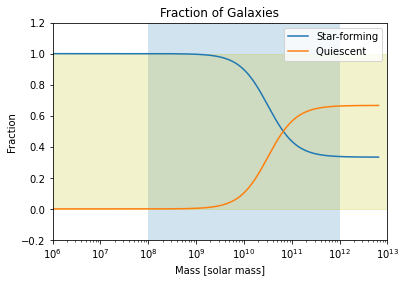

In [9]:
b = 10.5

def fract(z, c, b):
    a = ma*(z-a1[0]) + a1[1]
#     b = mb*(z-b1[0]) + b1[1]
    b = 10.5
    
#     print(b, tanh_m(10**b, a, -b, 3.1, 2.0) )
    
    f = tanh_m(pop.SMHM(z, 0), a, -b, 3.0, 2.0) 
   
    return f

'''
a - slope, must be -ve (more negative, steep = faster change)
    --> funct of z, more negative with higher z
b - peak, switch which one is bigger
c - vertical width (bigger = narrower)
d - shift vertically (up = bigger)
'''

#SM
z = 1.75
minM = 11
maxM = 14.5

pl.axvspan(10**8, 10**12, alpha=0.2)
pl.semilogx(pop.SMHM(z, 0), fract(z, minM, b), label="Star-forming")
pl.semilogx(pop.SMHM(z, 0), 1-fract(z, minM, b), label="Quiescent ")
pl.axhspan(0, 1, alpha=0.2, color="y")

pl.xlim(1e6, 1e13)
pl.ylim(-0.2, 1.2)

pl.ylabel('Fraction')
pl.xlabel('Mass [solar mass]')

pl.title("Fraction of Galaxies")
pl.legend()
pl.show()

In [10]:
minM = 1

b1 = [1.75, np.log10(1.9e11)] #10.84
b2 = [0.875, np.log10(5.7e10)] #10.05

for i, ele in enumerate(fract(0.875, minM, 10.05)):
    
    if 0.497 < ele < 0.502:
        print("{:e}".format(pop.SMHM(z, 0)[i]))


1.713778e+11
1.730202e+11
1.746666e+11
1.763171e+11
1.779719e+11


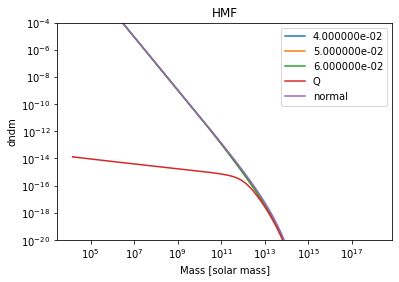

In [11]:
z = 2

# for c in [1e-18, 1e-19, 1e-20]:
for c in [0.04, 0.05, 0.06]:

    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*fract(c, 1, 1), label='%e' %c)

pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*(1-fract(1, 1, 1)), label='Q')
    
pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :], label='normal')
pl.legend()
pl.ylabel('dndm')
pl.xlabel('Mass [solar mass]')
pl.title('HMF')

pl.ylim(1e-20, 1e-4)
pl.show()

In [12]:
# derivative of m(M) wrt M
def dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    n2 = (-beta)*(pop_halo.halos.tab_M**(-beta-1)/M_1**(-beta)) + gamma*(pop_halo.halos.tab_M**(gamma-1)/M_1**(gamma))
    
    dydx = mM_ratio - pop_halo.halos.tab_M * 2 * N * n2 * ( (pop_halo.halos.tab_M/M_1)**(-beta) + \
                                                            (pop_halo.halos.tab_M/M_1)**(gamma) )**(-2) 

    return dydx

#derivative of log10( m ) wrt M
def dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    
    dydx = -1* ((gamma-1)*(pop_halo.halos.tab_M/M_1)**(gamma+beta) - beta - 1) / (np.log(10)*pop_halo.halos.tab_M*((pop_halo.halos.tab_M/M_1)**(gamma+beta) + 1))

    return dydx

In [13]:
#double power law
c = 0.05
b = 1

def SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='sf'):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10( 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2
    
    """
    tab_dndm (halo) -> dndlog(m) (SM)
    need: tab_dndm / d(log(ratio)/dM
    """
    
    if sf == 'sf': #star-forming 
        SMF = pop_halo.halos.tab_dndm[k, :]*fract(z, c, b) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
    elif sf == 'q': # quiescent
        SMF = pop_halo.halos.tab_dndm[k, :]*(1-fract(z, c, b)) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
    else: # total
        SMF = pop_halo.halos.tab_dndm[k, :] / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
    
    return SMF,  mM_ratio

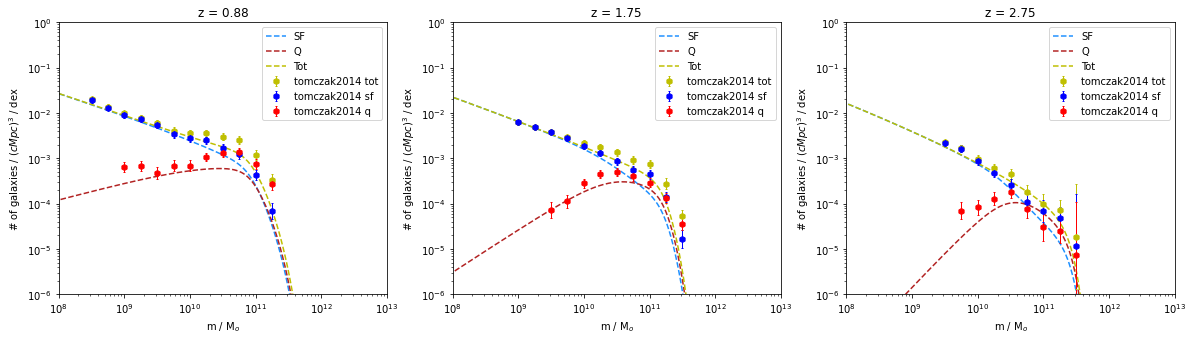

In [14]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

# [(0.35) sf only, 0.875, 1.125, 1.75, 2.25, 2.75]

for i, z in enumerate([0.875, 1.75, 2.75]):
    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0)*(z+1)**mu
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
       
    #plot lit values
    data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 tot", quantity="smf_tot", ax=axs[i])
    data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 sf", ax=axs[i], color="b", ecolor='b',  mec='b')
    data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 q", quantity="smf_q", ax=axs[i])
    
    SMF_sf, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='sf')
    SMF_q, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='q')
    SMF_tot, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='tot')

    #using equ 2 to get the new stellar masses
    Sm = 10**(r + np.log10(pop_halo.halos.tab_M))
    
    HM = pop_halo.halos.tab_M

    #plotting
    axs[i].loglog(Sm, SMF_sf, label='SF', ls="--", color='dodgerblue')
    axs[i].loglog(Sm, SMF_q, label='Q', ls="--", color='firebrick')
    axs[i].loglog(Sm, SMF_tot, label='Tot', ls="--", color='y')
    
    
    axs[i].set_title("z = %.2f" %z)
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
    axs[i].set_xlim(1e8, )

    axs[i].legend()

pl.show()

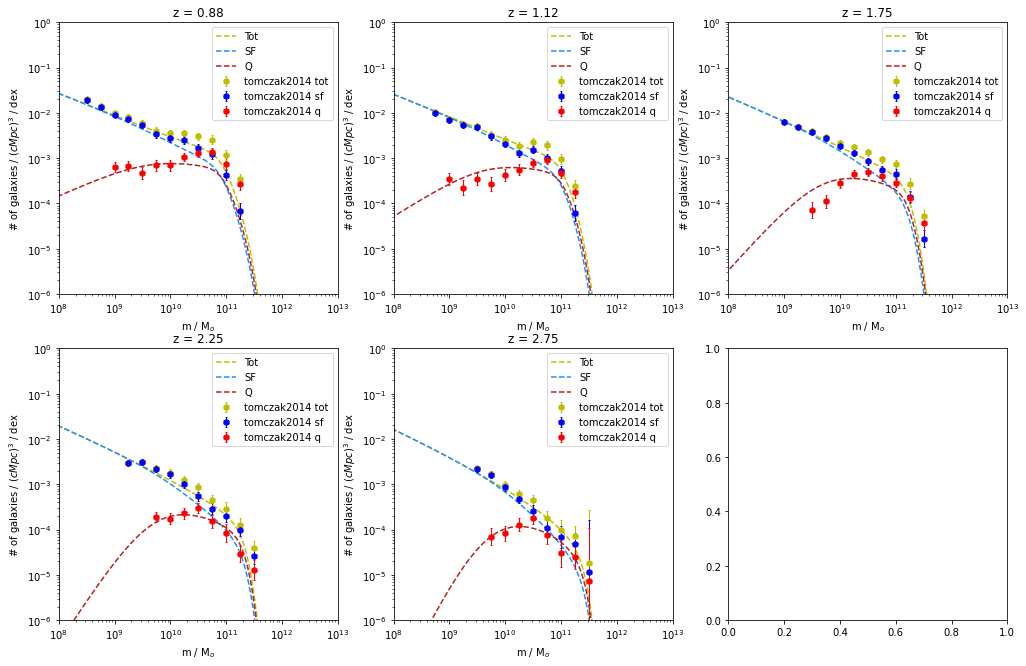

In [12]:
zArr = [0.875, 1.125, 1.75, 2.25, 2.75]

fig, axs = pl.subplots(2, 3, figsize=(17, 11))
axs = axs.flat

for i, z in enumerate(zArr):
        #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0)*(z+1)**mu
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
       
    #plot lit values
    data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 tot", quantity="smf_tot", ax=axs[i])
    data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 sf", ax=axs[i], color="b", ecolor='b',  mec='b')
    data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 q", quantity="smf_q", ax=axs[i])
    
    SMF_sf, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='sf')
    SMF_q, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='q')
    SMF_tot, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='tot')

    #using equ 2 to get the new stellar masses
    Sm = 10**(r + np.log10(pop_halo.halos.tab_M))
    
    HM = pop_halo.halos.tab_M

    #plotting
    axs[i].loglog(Sm, SMF_tot, label='Tot', ls="--", color='y')
    axs[i].loglog(Sm, SMF_sf, label='SF', ls="--", color='dodgerblue')
    axs[i].loglog(Sm, SMF_q, label='Q', ls="--", color='firebrick')
    
    
    axs[i].set_title("z = %.2f" %z)
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
    axs[i].set_xlim(1e8, )

    axs[i].legend()

And again another new less linear function.   
$SF_{fract} = \frac{1}{b} [tanh(a \cdot (log_{10}(SM) + b) + d]$   

$a(z) = a_0 \cdot (z + 1)^{a_1}$   
$b(z) = b_0 \cdot (z + 1)^{b_1}$

$c(z) = m_c \cdot (z - c_1) + c_0$   
$d(z) = m_d \cdot (z - d_1) + d_0$

In [13]:
# from scipy.optimize import curve_fit
# scipy.optimize.curve_fit

def getData(z):
    dataTot = data.compile_data(z, sources="tomczak2014", round_z=False, quantity='smf_tot')['tomczak2014']
    dataSf = data.compile_data(z, sources="tomczak2014", round_z=False, quantity='smf_sf')['tomczak2014']
    dataQ = data.compile_data(z, sources="tomczak2014", round_z=False, quantity='smf_q')['tomczak2014']

    return dataTot, dataSf, dataQ


In [43]:
def tanh_m(m, a, b, c, d):   
#     return (np.tanh(a*(np.log10(m) + b)) + 1)/2
    return (np.tanh(a*(np.log10(m) + b)) + d)/c

a0 = -3.5
a1 = 0.1

b0 = 10
b1 = 0.1

def fract(z, c, b):
    a = a0*(z+1)**(a1)
    b = b0*(z+1)**(b1)
    c = 2.8 + 0.6*z
    d = 1.5 + 0.6*z
    
    f = tanh_m(pop.SMHM(z, 0), a, -b, c, d) 
   
    return f
'''
a - slope, must be -ve (more negative, steep = faster change)
    --> funct of z, more negative with higher z
b - peak, switch which one is bigger
c - vertical width (bigger = narrower)
d - shift vertically (up = bigger)
'''
q = 1

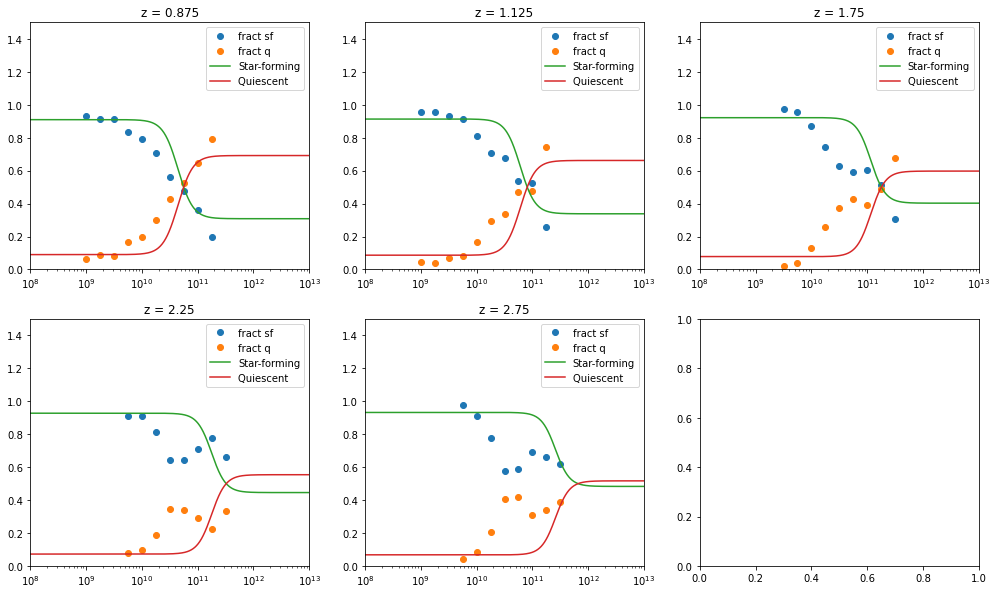

In [44]:
x = [2, 1, 2, 2, 1]
fig, axs = pl.subplots(2, 3, figsize=(17, 10))
ax = axs.flat

for i, z in enumerate(zArr):

    dataTot, dataSf, dataQ = getData(z)

    fract_sf = dataSf['phi'][x[i]:]/dataTot['phi'][x[i]:]
    fract_q = dataQ['phi']/dataTot['phi'][x[i]:]

    ax[i].semilogx(dataSf['M'][x[i]:], fract_sf, label="fract sf", ls="", marker="o")
    ax[i].semilogx(dataSf['M'][x[i]:], fract_q, label="fract q", ls="", marker="o")
#     pl.yscale('log')

    ax[i].semilogx(pop.SMHM(z, 0), fract(z, minM, b), label="Star-forming")
    ax[i].semilogx(pop.SMHM(z, 0), 1-fract(z, minM, b), label="Quiescent ")
    
    ax[i].set_title("z = {}".format(z))
    ax[i].legend()
    ax[i].set_ylim(0, 1.5)
    ax[i].set_xlim(1e8, 1e13)

# pl.title("z = %.2f" %z)
pl.show()

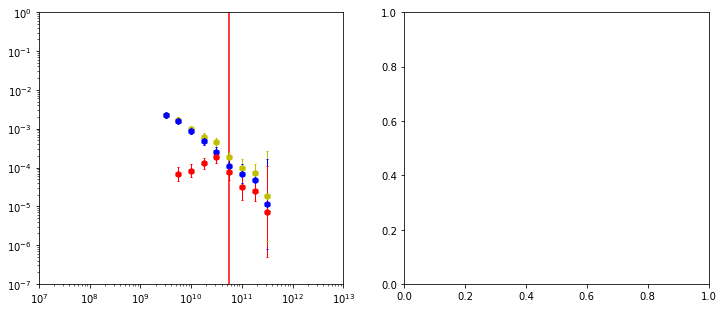

In [17]:
z = 2.75
fig, axs = pl.subplots(1, 2, figsize=(12, 5))
i = 0

axs[i].axvline(5.7e10, ymin=0, ymax=1, color="r")

data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 tot", quantity="smf_tot", ax=axs[i])
data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 sf", ax=axs[i], color="b", ecolor='b',  mec='b')
data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 q", quantity="smf_q", ax=axs[i])

pl.show()